In [25]:
import csv
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('../Lib/PythonML')

from linear import Linear
from multicouche import MLP
from svm import SVM 
from random import randrange
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D

In [26]:
labels = ['guitare','saxo', 'piano']
use_real_dataset = True
dll_path = '../Lib/SupervisingML/target/debug/libmllib_rust.so'
if use_real_dataset:
    train_path = '../Dataset/Train/Fourier'
    validation_path = '../Dataset/Test/Fourier'
else:
    train_path = 'Tensorflow/Fourier/dataset/train'
    validation_path = 'Tensorflow/Fourier/dataset/validation'

# Fourier

In [27]:
number_of_label = 2
train_max_by_label = 50
frequency_max = 8000
frequency_precision = 2

In [28]:
def getCsvData(path):
    with open(path, newline='\n') as f:
        reader = csv.reader(f, delimiter=';')
        next(reader, None)
        data = [] 
        count = 0
        #0,1 -> 0 2,3 -> 1 4,5 -> 2
        for row in reader:
            if len(data) == (frequency_max * 2) / frequency_precision:
                break
            if count % frequency_precision != 0:
                count += 1
                continue
    
            frequency = float(row[0])
            if frequency > frequency_max:
                break
            if int(frequency) * 2 + 1 < count:
                continue
            count += 1
            data.append([float(row[0]), float(row[1])])
        return data

def importData(path, label_number = len(labels), max_by_label = -1):
    data = []
    label = []
    if label_number > len(labels):
        label_number = len(labels)
    for i in range(label_number):
        data_count_by_label = 0
        directory_path = os.path.join(path, labels[i])
        for r, _, f in os.walk(directory_path):
            for file in f:
                if data_count_by_label == max_by_label and max_by_label != -1:
                    break
                
                data_buff = getCsvData(os.path.join(directory_path, file))
                if len(data_buff) == (frequency_max * 2) / frequency_precision:
                    data.append(data_buff)
                    if i == 0 and label_number == 2:
                        label.append(-1)
                    else:
                        label.append(i)
                    data_count_by_label += 1

    return (np.array(data, dtype='float64'), np.array(label, dtype='float64'))

def shuffle(data,label):
    for i in range(len(label)):
        rand = random.randrange(i,len(label))
        label[i], label[rand] = label[rand], label[i]
        data[i], data[rand] = data[rand], data[i]
    return (data,label)

def max_indice(values):
    max_value = values[0]
    max_ind = 0
    for i in range(1, len(values)):
        if values[i] > max_value:
            max_ind = i
            max_value = values[i]
    return max_ind

def test_linear(data, label):
    good_predict = [0,0]
    number_of_predict = [0,0]
    for i in range(len(data)):
        predicted_value = linear.predict_linear_model_classification(data[i])
        if label[i] == -1.0:
            number_of_predict[0] += 1
            if predicted_value == -1.0:
                good_predict[0] += 1
        else:
            number_of_predict[1] += 1
            if predicted_value == 1.0:
                good_predict[1] += 1
    return (good_predict, number_of_predict)

def test_mlp(model, data, label, last_couche):
    good_predict = [0 for i in range(last_couche + 1)]
    number_of_predict = [0 for i in range(last_couche + 1)]
    for i in range(len(data)):
        predicted_value = model.predict_multicouche_model_classification(data[i])
        if last_couche == 1:
            predicted_value = predicted_value[0]
            if label[i] < 0.0:
                number_of_predict[0] += 1
                if predicted_value < 0.0:
                    good_predict[0] += 1
            else:
                number_of_predict[1] += 1
                if predicted_value >= 0.0:
                    good_predict[1] += 1
        else:
            predicted_list = [predicted_value[i] for i in range(last_couche)]
            max_ind = max_indice(predicted_list)  
            number_of_predict[int(label[i]) + 1] += 1
            if int(label[i]) == max_ind:
                good_predict[int(label[i]) +  1] += 1
    return (good_predict, number_of_predict)

## Linear

### 2 Classes

In [33]:
number_of_label = 2
train_max_by_label = 60
train_data, train_label = importData(train_path, number_of_label, train_max_by_label)
validation_data, validation_label = importData(validation_path, number_of_label, train_max_by_label // 2)

print("Import Finish")
print(train_data.shape)
print(train_label.shape)

train_data, train_label = shuffle(train_data, train_label)
validation_data, validation_label = shuffle(validation_data, validation_label)  

Import Finish
(120, 8000, 2)
(120,)


### Keras

In [30]:
train_label_cat = to_categorical(train_label, 2)
validation_label_cat = to_categorical(validation_label, 2)

model = Sequential()
model.add(keras.layers.Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(1, activation='tanh'))
#model.summary()

model.compile(optimizer = 'adam',  loss="mean_squared_error",  metrics=['accuracy'])
history = model.fit(train_data, train_label_cat, 
                    validation_data=(validation_data, validation_label_cat), epochs= 10)

Epoch 1/10
25/25 [==============================] - 0s 11ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 8/10
25/25 [=

### Lib Rust

In [39]:
linear = Linear(dll_path)
linear.init_linear_model(((frequency_max * 2) // frequency_precision) * 2)
linear.train_linear_model_classification(train_data.flatten(), train_label.flatten(), len(train_label), 10000, 0.3)

good_predict, number_of_predict = test_linear(validation_data, validation_label)
#print("predicted result : " + str(predicted_value) + " / result : " + str(validation_label[i]))
print("Test :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

good_predict, number_of_predict = test_linear(train_data, train_label)
print("Train :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

Test :
Predict of -1.0 : 11 of 30
Predict of 1.0 : 23 of 30
Train :
Predict of -1.0 : 51 of 60
Predict of 1.0 : 34 of 60


## MLP

In [15]:
number_of_label = 3
train_max_by_label = 300
train_data, train_label = importData(train_path, number_of_label, train_max_by_label)
validation_data, validation_label = importData(validation_path, number_of_label, train_max_by_label // 2)

print("Import Finish")
print(train_data.shape)
print(train_label.shape)

train_data, train_label = shuffle(train_data, train_label)
validation_data, validation_label = shuffle(validation_data, validation_label)  

Import Finish
(120, 8000, 2)
(120,)


### Keras

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2048128   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 2,065,027
Trainable params: 2,065,027
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 83ms/step - loss: 1.3007 - accuracy: 0.2917 - val_loss: 1.2482 - val_accuracy: 0.3158
Epoch 2/100
4/4 [==============================] - 0s 41ms/step - loss: 1.2265 - accuracy: 0.2833 - va

Epoch 53/100
4/4 [==============================] - 0s 40ms/step - loss: 1.1093 - accuracy: 0.2917 - val_loss: 1.0968 - val_accuracy: 0.3684
Epoch 54/100
4/4 [==============================] - 0s 47ms/step - loss: 1.1154 - accuracy: 0.2500 - val_loss: 1.1004 - val_accuracy: 0.3158
Epoch 55/100
4/4 [==============================] - 0s 42ms/step - loss: 1.1030 - accuracy: 0.3333 - val_loss: 1.0971 - val_accuracy: 0.3684
Epoch 56/100
4/4 [==============================] - 0s 30ms/step - loss: 1.1122 - accuracy: 0.3333 - val_loss: 1.1025 - val_accuracy: 0.3684
Epoch 57/100
4/4 [==============================] - 0s 47ms/step - loss: 1.1075 - accuracy: 0.3250 - val_loss: 1.1033 - val_accuracy: 0.3158
Epoch 58/100
4/4 [==============================] - 0s 47ms/step - loss: 1.1054 - accuracy: 0.3333 - val_loss: 1.1012 - val_accuracy: 0.3158
Epoch 59/100
4/4 [==============================] - 0s 31ms/step - loss: 1.1025 - accuracy: 0.3167 - val_loss: 1.0971 - val_accuracy: 0.3684
Epoch 60/100


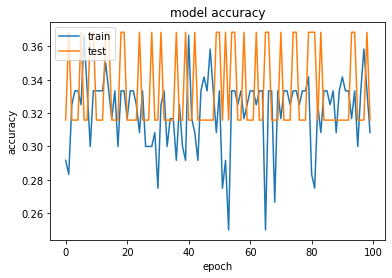

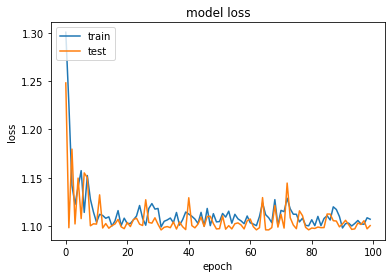

In [16]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_data.shape[1:]),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
history = model.fit(train_data, train_label, validation_data=(validation_data, validation_label), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Lib Rust

In [27]:
last_couche = 3

mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([train_data.shape[1] * train_data.shape[2], 16, 2, last_couche], dtype='float64'))
mlp.train_multicouche_model_classification(train_data.flatten(), train_label.flatten(), train_data.shape[0], 1000.0, 0.03)

good_predict, number_of_predict = test_mlp(mlp, validation_data, validation_label, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 12, 0]
[0, 12, 12, 14]


# Spectrogram

In [17]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import sys

sys.path.append('../Lib/PythonML')
from linear import Linear
from multicouche import MLP
from tensorflow import keras
from random import randrange

In [18]:
use_real_dataset = True
class_names = ['piano', 'guitare', 'saxo']
max_data_by_label = 1500
IMG_HEIGHT = 32
IMG_WIDTH = 32
dll_path = '../Lib/SupervisingML/target/debug/libmllib_rust.so'


target_size = (IMG_WIDTH, IMG_HEIGHT)
ORIGINAL_IMG_HEIGHT = 109
ORIGINAL_IMG_WIDTH = 146
if use_real_dataset:
    train_path = '../Dataset/Train/Spectrogram'
    validation_path = '../Dataset/Test/Spectrogram'
else:
    train_path = 'Tensorflow/Spectrogram/dataset/train'
    validation_path = 'Tensorflow/Spectrogram/dataset/validation'

In [19]:
def shuffle(data,label):
    for i in range(len(label)):
        rand = random.randrange(i,len(label))
        label[i], label[rand] = label[rand], label[i]
        data[i], data[rand] = data[rand], data[i]
    return (data,label)

def test(model, data, label, last_couche):
    good_predict = [0 for i in range(last_couche + 1)]
    number_of_predict = [0 for i in range(last_couche + 1)]
    for i in range(len(data)):
        predicted_value = model.predict_multicouche_model_classification(data[i])
        if last_couche == 1:
            predicted_value = predicted_value[0]
            if label[i] == 0.0:
                number_of_predict[0] += 1
                if predicted_value < 0.0:
                    good_predict[0] += 1
            else:
                number_of_predict[1] += 1
                if predicted_value >= 0.0:
                    good_predict[1] += 1
        else:
            predicted_list = [predicted_value[i] for i in range(last_couche)]
            max_ind = max_indice(predicted_list)  
            number_of_predict[int(label[i]) + 1] += 1
            if int(label[i]) == max_ind:
                good_predict[int(label[i]) +  1] += 1
    return (good_predict, number_of_predict)

def max_indice(values):
    max_value = values[0]
    max_ind = 0
    for i in range(1, len(values)):
        if values[i] > max_value:
            max_ind = i
            max_value = values[i]
    return max_ind

In [21]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1) // 2:
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(4500, 32, 32, 3)
(4500,)


### Keras

In [24]:
'''
Epoch 6/100
141/141 [==============================] - 10s 68ms/step - loss: 1.0381 - accuracy: 0.4764 - 
val_loss: 1.0947 - val_accuracy: 0.4854

'''
model = keras.models.Sequential([
    keras.layers.Conv2D(8, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(16, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    #over-fitting
    keras.layers.Conv2D(128, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(len(class_names), activation=keras.activations.softmax)
])

#MeanSquaredError les résultats ne montent pas

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/100
141/141 [==============================] - 8s 55ms/step - loss: 1.1000 - accuracy: 0.3464 - val_loss: 1.1032 - val_accuracy: 0.2390
Epoch 2/100
141/141 [==============================] - 10s 71ms/step - loss: 1.0869 - accuracy: 0.3916 - val_loss: 1.1027 - val_accuracy: 0.2187
Epoch 3/100
141/141 [==============================] - 10s 69ms/step - loss: 1.0686 - accuracy: 0.4273 - val_loss: 1.1023 - val_accuracy: 0.2449
Epoch 4/100
141/141 [==============================] - 9s 63ms/step - loss: 1.0531 - accuracy: 0.4462 - val_loss: 1.0993 - val_accuracy: 0.3049
Epoch 5/100
141/141 [==============================] - 9s 66ms/step - loss: 1.0444 - accuracy: 0.4578 - val_loss: 1.0995 - val_accuracy: 0.3521
Epoch 6/100
141/141 [==============================] - 10s 68ms/step - loss: 1.0381 - accuracy: 0.4764 - val_loss: 1.0947 - val_accuracy: 0.4854
Epoch 7/100
141/141 [==============================] - 9s 66ms/step - loss: 1.0228 - accuracy: 0.4931 - val_loss: 1.0986 - val_accura

KeyboardInterrupt: 

In [50]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images.shape[1:]),
    keras.layers.Dense(512, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/100
107/107 [==============================] - 1s 12ms/step - loss: 0.3367 - accuracy: 0.0871 - val_loss: 0.2528 - val_accuracy: 0.0000e+00
Epoch 2/100
107/107 [==============================] - 1s 10ms/step - loss: 0.2562 - accuracy: 0.2206 - val_loss: 0.2525 - val_accuracy: 0.4844
Epoch 3/100
107/107 [==============================] - 1s 11ms/step - loss: 0.2586 - accuracy: 0.1847 - val_loss: 0.2538 - val_accuracy: 0.0000e+00
Epoch 4/100
107/107 [==============================] - 1s 10ms/step - loss: 0.2542 - accuracy: 0.2274 - val_loss: 0.2506 - val_accuracy: 0.3398
Epoch 5/100
107/107 [==============================] - 1s 10ms/step - loss: 0.2550 - accuracy: 0.2815 - val_loss: 0.2539 - val_accuracy: 0.5156
Epoch 6/100
107/107 [==============================] - 1s 11ms/step - loss: 0.2567 - accuracy: 0.2044 - val_loss: 0.2522 - val_accuracy: 0.4844
Epoch 7/100
107/107 [==============================] - 1s 11ms/step - loss: 0.2580 - accuracy: 0.2724 - val_loss: 0.2508 - val_a

KeyboardInterrupt: 

### Lib Rust

In [ ]:
last_couche = 2
mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([IMG_HEIGHT * IMG_WIDTH * 3, 256, 64, 32, 8, last_couche], dtype='float64'))
mlp.activation_function = mlp.ActivationFunction.Relu

mlp.train_multicouche_model_classification(train_images.flatten(), train_labels.flatten(), train_images.shape[0], 100.0, 0.2)


good_predict, number_of_predict = test(mlp, validation_images, validation_labels, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

# Spectrogram Studio (light)

In [11]:
class_names = ['piano', 'saxo','guitare']
max_data_by_label = 500
max_val_by_label = 50
IMG_HEIGHT = 64
IMG_WIDTH = 64
dll_path = '../Lib/SupervisingML/target/debug/libmllib_rust.so'


target_size = (IMG_WIDTH, IMG_HEIGHT)
ORIGINAL_IMG_HEIGHT = 109
ORIGINAL_IMG_WIDTH = 146
#train_path = '/home/losabit/Desktop/dataset_light/spectro/'
#validation_path = '../Dataset/Test/Spectrogram'
#train_path = '/home/losabit/Desktop/dataset_light/train_val/train'
#validation_path = '/home/losabit/Desktop/dataset_light/train_val/validation'
train_path = '/home/losabit/Desktop/dataset_light/train_val_clean/train'
validation_path = '/home/losabit/Desktop/dataset_light/train_val_clean/validation'

In [12]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(1500, 64, 64, 3)
(1500,)


Epoch 1/100
44/44 [==============================] - 4s 84ms/step - loss: 0.6939 - accuracy: 0.5400 - val_loss: 0.6984 - val_accuracy: 0.4196
Epoch 2/100
44/44 [==============================] - 4s 97ms/step - loss: 0.6733 - accuracy: 0.5764 - val_loss: 0.6992 - val_accuracy: 0.4157
Epoch 3/100
44/44 [==============================] - 5s 109ms/step - loss: 0.6614 - accuracy: 0.6043 - val_loss: 0.7030 - val_accuracy: 0.5608
Epoch 4/100
44/44 [==============================] - 4s 102ms/step - loss: 0.6475 - accuracy: 0.6200 - val_loss: 0.7025 - val_accuracy: 0.5529
Epoch 5/100
44/44 [==============================] - 4s 89ms/step - loss: 0.6445 - accuracy: 0.6321 - val_loss: 0.6981 - val_accuracy: 0.5569
Epoch 6/100
44/44 [==============================] - 4s 97ms/step - loss: 0.6507 - accuracy: 0.6264 - val_loss: 0.6913 - val_accuracy: 0.5647
Epoch 7/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6461 - accuracy: 0.6236 - val_loss: 0.6991 - val_accuracy: 0.5490
Epoc

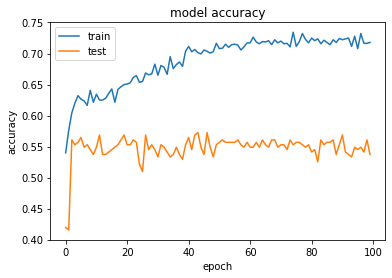

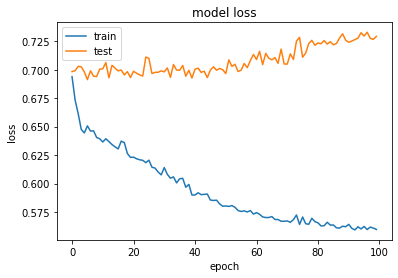

In [19]:
model = keras.models.Sequential([
    keras.layers.Conv2D(8, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(16, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    #keras.layers.Conv2D(64, (3, 3), padding='same', activation=keras.activations.tanh),
    #keras.layers.MaxPool2D(),
    #over-fitting
    #keras.layers.Conv2D(128, (3, 3), padding='same', activation=keras.activations.tanh),
    #keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(len(class_names), activation=keras.activations.softmax)
])

#MeanSquaredError les résultats ne montent pas

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 3 classes

Epoch 1/10
47/47 [==============================] - 4s 81ms/step - loss: 1.1000 - accuracy: 0.3520 - val_loss: 1.1019 - val_accuracy: 0.3333
Epoch 2/10
47/47 [==============================] - 5s 97ms/step - loss: 1.0841 - accuracy: 0.4060 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 3/10
47/47 [==============================] - 4s 76ms/step - loss: 1.0779 - accuracy: 0.4293 - val_loss: 1.0986 - val_accuracy: 0.3533
Epoch 4/10
47/47 [==============================] - 4s 95ms/step - loss: 1.0595 - accuracy: 0.4453 - val_loss: 1.0976 - val_accuracy: 0.3733
Epoch 5/10
47/47 [==============================] - 5s 97ms/step - loss: 1.0462 - accuracy: 0.4780 - val_loss: 1.0946 - val_accuracy: 0.3933
Epoch 6/10
47/47 [==============================] - 4s 90ms/step - loss: 1.0330 - accuracy: 0.4907 - val_loss: 1.1023 - val_accuracy: 0.3467
Epoch 7/10
47/47 [==============================] - 4s 77ms/step - loss: 1.0278 - accuracy: 0.4907 - val_loss: 1.1038 - val_accuracy: 0.3200
Epoch 8/10
47

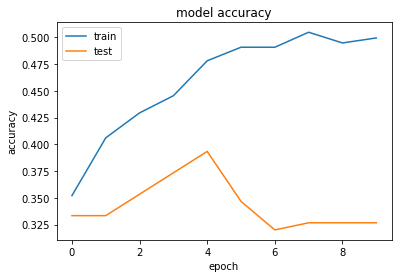

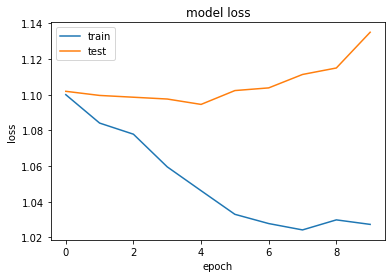

In [16]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(16, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(len(class_names), activation=keras.activations.softmax)
])

#MeanSquaredError les résultats ne montent pas

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=10)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
last_couche = 3
mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([IMG_HEIGHT * IMG_WIDTH * 3, 64, 64, 32, 8, last_couche], dtype='float64'))
mlp.activation_function = mlp.ActivationFunction.Tanh

mlp.train_multicouche_model_classification(train_images.flatten(), train_labels.flatten(), train_images.shape[0], 100.0, 0.2)
mlp.save_model("../App/interfacev2/Models/mlp.txt")

good_predict, number_of_predict = test(mlp, validation_images, validation_labels, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 50, 0]
[0, 50, 50, 50]
